In [1]:
# Домашнее задание 2: DPO и PPO

В этой домашке поближе познакомимся с двумя крайне популярными методами алаймента языковых моделей. В первой части вам предоставится возможность самостоятельно заимплементить DPO c нуля. Во второй части мы уже будем использовать библиотеку TRL и обучим PPO.

Обученные модели можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). Зарегистрируйтесь там, подпишитесь на [deep vk](https://huggingface.co/deepvk) и создайте себе API токен.

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

## Импорты и вспомогательные функции

In [5]:
# Установим необходимые дополнительные библиотеки

%pip install --quiet datasets trl

Note: you may need to restart the kernel to use updated packages.


In [6]:
import inspect
import random
from functools import partial

import numpy as np
import torch
import torch.nn.functional as F
import wandb
from datasets import load_dataset
from huggingface_hub import HfApi, interpreter_login
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    PreTrainedTokenizerBase,
)
from trl import PPOConfig, PPOTrainer, RewardConfig, RewardTrainer

In [7]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



Enter your token (input will not be visible):  ········
Add token as git credential? (Y/n)  


In [8]:

username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw2"  

print(f"Homework repository: '{REPO_NAME}'")

Homework repository: 'Pavelslavovich/llm-course-hw2'


In [9]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


def disable_dropout_in_model(model):
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = 0

# Часть 1: DPO

Крайне простой метод, который в свое время произвел фурор, т.к. выгодно выделялся на фоне PPO. В отличие от PPO, требующего отдельно обучать Reward Model, Value Model и больших усилий в имплементации, DPO не требует явной ревард модели, а только датасета с человеческими преференсами вида: промпт, выбранный человеком ответ, отвергнутный человеком ответ. Простота также видна из лосса, по сути это весь метод:
$$
L_\text{DPO}(\pi_{\theta}; \pi_\text{ref}) = -E_{(x, y_w, y_l)\sim D}\left[\log \sigma \left(
\beta \log \frac{\pi_{\theta}(y_w\mid x)}{\pi_\text{ref}(y_w\mid x)} \thinspace
{- \beta \log \frac{\pi_{\theta}(y_l\mid x)}{\pi_\text{ref}(y_l\mid x)}}\right)\right]
$$

где:

- $\pi_{\theta}$ LLM которую мы хотим заалайнить
- $\pi_\text{ref}$ референсная модель для регуляризации, как правило просто начальный чекпоинт
- $D$ датасет с преференсами
- $x$ промпт из датасета $D$
- $y_w$ ответ на промпт $x$ выбранный человеком (или тем кто размечал преференсы, это может быть и большая LLM)
- $y_l$ ответ на промпт $x$ отвергнутый человеком (или тем кто размечал преференсы, это может быть и большая LLM)
- $\beta$ гиперепараметр отвечающий за то, как далеко мы можем отходить от референсной модели

Во время имплементации советум внимательно прочитать оригинальную статью: [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290).

Для файнтюна мы будем использовать модель [HuggingFaceTB/SmolLM-135M-Instruct](https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct), т.к. она маленького размера (поместится на Colab), но при этом умеет достаточно, чтобы увидеть изменения от алаймента. Более того, данная модель даже прошла стадию SFT, а поэтому в отличие от базовой модели (без Instruct) понимает формат чата (chat-template в transformers, дальше разберем) и имеет 'осознание' себя языковым ассистентом.

P.S. Если у вас есть доступ к вычислительным ресурсам типо A100 и больше, вы можете попробовать зафайнтюнить модель большего размера из этой же [линейки](https://huggingface.co/blog/smollm). Будьте внимательны, смотрите, чтобы она была с добавкой Instruct.

In [10]:
MODEL_ID = "HuggingFaceTB/SmolLM-135M-Instruct"
DATASET_ID = "HumanLLMs/Human-Like-DPO-Dataset"

## Подготовка данных [2 балла]

Для начала нужно подготовить данные. В качестве датасета преференсов мы будем использовать [HumanLLMs/Human-Like-DPO-Dataset](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset), который значительно повышает эмоциональность модели, количество используемых эмодзи и в целом снижает строгость следования шаблону "As a conversational AI, I ...".

Чтобы подготовить датасет нужно несколько простых этапов:
1. Привест данные к формату chat-template
2. После применить этот chat-template с помощью 'tokenizer.apply_chat_template'
3. Токенизировать получившиеся данные, попутно обрезав промпт и ответы до нужной длины, если надо.

Внимательно прочитайте [документацию по chat-templates](https://huggingface.co/docs/transformers/chat_templating). Для удобства данные приводят в начале в более верхне-уровневый формат такого вида:
```python
messages = [
    {"role": "system", "content": "You are a helpful assistant focused on technical topics."},
    {"role": "user", "content": "Can you explain what a chat template is?"},
    {"role": "assistant", "content": "A chat template structures conversations between users and AI models..."}
]
```
То есть модели можно задать разные роли, такие как например системный промпт, и в целом структурировать диалог между ассистентом и человеком. Обычно обучение этому происходит на этапе SFT. Данная репрезентация абстрагирует детали (конкретные токены) как этот формат используют разные модели. Чтобы перевести его в неспоредственно текстовый инпут в формате специфичном конкретной модели используется `tokenizer.apply_chat_template`.

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

In [12]:
dataset = load_dataset(DATASET_ID, split="train")
dataset[0]

{'prompt': 'Oh, I just saw the best meme - have you seen it?',
 'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣",
 'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?"}

Приведите датасет к формату чата, где у промпта роль user, а у ответов assistant, а потом примените чат темплейт:

In [13]:
def apply_chat_template(example: dict[str, str], tokenizer: PreTrainedTokenizerBase) -> dict[str, str]:
    
    chosen_messages = [
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["chosen"]}
    ]
    
    rejected_messages = [
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["rejected"]}
    ]
    
    prompt_messages = [{"role": "user", "content": example["prompt"]}]
    prompt = tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True)
    
    chosen_text = tokenizer.apply_chat_template(chosen_messages, tokenize=False)
    rejected_text = tokenizer.apply_chat_template(rejected_messages, tokenize=False)
    
    assistant_start = "<|im_start|>assistant\n"
    chosen = chosen_text.split(assistant_start, 1)[1]
    rejected = rejected_text.split(assistant_start, 1)[1]
    
    return {
        "prompt": prompt,
        "chosen": chosen,
        "rejected": rejected
    }

In [14]:
dataset = dataset.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer})
dataset[0]

{'prompt': '<|im_start|>user\nOh, I just saw the best meme - have you seen it?<|im_end|>\n<|im_start|>assistant\n',
 'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>\n",
 'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?<|im_end|>\n"}

После этих двух этапов данные должны выглядеть так (**обратите внимание на положение <|im_start|>assistant\n**, это важно!):
```
{
    'prompt': "<|im_start|>user\nOh, I just saw the best meme - have you seen it <|im_end|>\n<|im_start|>assistant\n",
    'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>\n",
    'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?<|im_end|>\n"
}
```

Токенизируйте датасет с помощью токенизатора, обрезав длину если необходимо. В датасете должны остаться только ID токенов:
```
Dataset({
    features: ['prompt_input_ids', 'chosen_input_ids', 'rejected_input_ids'],
    num_rows: 10884
})
```

Обрезайте промпт слева, а не с конца. Подумайте почему так лучше. **Напишите свой ответ**.

    #========== TODO ==========
    #     Ваш ответ здесь     =
    #==========================

In [15]:
def tokenize_row(
    example: dict[str, str],
    tokenizer: PreTrainedTokenizerBase,
    max_prompt_length: int = 512,
    max_completion_length: int | None = None,
) -> dict[str, list[int]]:
    
    prompt_tokens = tokenizer(example["prompt"], return_tensors="pt")["input_ids"][0]
    if max_prompt_length is not None and len(prompt_tokens) > max_prompt_length:
        prompt_tokens = prompt_tokens[-max_prompt_length:]
    
    
    chosen_tokens = tokenizer(example["chosen"], return_tensors="pt")["input_ids"][0]
    if max_completion_length is not None and len(chosen_tokens) > max_completion_length:
        chosen_tokens = chosen_tokens[:max_completion_length]
    
    
    rejected_tokens = tokenizer(example["rejected"], return_tensors="pt")["input_ids"][0]
    if max_completion_length is not None and len(rejected_tokens) > max_completion_length:
        rejected_tokens = rejected_tokens[:max_completion_length]
    
    return {
        "prompt_input_ids": prompt_tokens.tolist(),
        "chosen_input_ids": chosen_tokens.tolist(),
        "rejected_input_ids": rejected_tokens.tolist()
    }
#Обрезка промпта слева (сохраняя последние токены) имеет несколько существенных преимуществ:
#1.Cохранение ключевой информации(Конец промта обычно имеет наиболее актуальную информацию)
#2.Контекстная релевантность(Последние сообщения имеют больший приоритет для формирования ответа)
#3.Специальные токены(В конце промпта часто располагаются специальные токены, указывающие на переход к генерации ответа ассистента. Их потеря при обрезке справа негативно влияет на качество ответов)

In [16]:
dataset = dataset.map(
    tokenize_row,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_prompt_length": 256,
        "max_completion_length": None,
    },
    remove_columns=["prompt", "chosen", "rejected"],
)

dataset[0]

{'prompt_input_ids': [1,
  4093,
  198,
  16912,
  28,
  339,
  915,
  3680,
  260,
  1450,
  1169,
  85,
  731,
  457,
  346,
  2269,
  357,
  47,
  2,
  198,
  1,
  520,
  9531,
  198],
 'chosen_input_ids': [10813,
  242,
  220,
  12947,
  28,
  787,
  339,
  8540,
  982,
  17,
  339,
  5248,
  11888,
  288,
  699,
  28,
  732,
  506,
  260,
  1169,
  85,
  563,
  47,
  1431,
  357,
  253,
  17025,
  2644,
  355,
  253,
  31404,
  3223,
  47,
  1691,
  388,
  260,
  9973,
  17,
  15107,
  114,
  113,
  2,
  198],
 'rejected_input_ids': [57,
  5248,
  354,
  6416,
  5290,
  1789,
  1743,
  28,
  339,
  1326,
  982,
  457,
  2143,
  2647,
  355,
  8428,
  30,
  1423,
  28,
  339,
  416,
  1538,
  346,
  351,
  1096,
  335,
  3452,
  29,
  3119,
  284,
  9603,
  32246,
  9411,
  28,
  347,
  876,
  347,
  7400,
  1552,
  335,
  1678,
  14009,
  355,
  5535,
  30,
  13651,
  346,
  702,
  549,
  288,
  1820,
  634,
  7703,
  10026,
  355,
  1692,
  253,
  1542,
  10265,
  282,
  1384,
  

Теперь надо подготовить DataLoader. Для этого надо написать кастомный `collate_fn` который будет делать следующее:
1. Принимать лист примеров с ключами `prompt_input_ids`, `chosen_input_ids`, `rejected_input_ids`.
2. Паддить до максимальной длины в батче по каждому ключу. По итогу `prompt_input_ids` и `chosen_input_ids` могут иметь разную длину, это нормально. Важно, чтобы внутри одинаковых ключей длина была консистентна.
3. Для каждого ключа создавать паддинг маску такого же шейпа, где 0 используется для паддинг-токенов и 1 для токенов последовательности.

Для паддинга дополнительно реализуйте функцию `pad`. В качестве токена используйте `tokenizer.pad_token_id` и 0 для маски. **Опять же, подумайте откуда лучше паддить `prompt_input_ids`?**

In [17]:
def pad(tensors: list[torch.Tensor], padding_value: int = 0, padding_side: str = "right") -> torch.Tensor:

    max_length = max(tensor.size(0) for tensor in tensors)
    
    batch_size = len(tensors)
    
    if len(tensors[0].size()) > 1:
        other_dims = tensors[0].size()[1:]
        padded_tensor = torch.full((batch_size, max_length, *other_dims), 
                                   padding_value, dtype=tensors[0].dtype, device=tensors[0].device)
    else:
        padded_tensor = torch.full((batch_size, max_length), 
                                   padding_value, dtype=tensors[0].dtype, device=tensors[0].device)
    for i, tensor in enumerate(tensors):
        length = tensor.size(0)
        if padding_side == "right":
            if len(tensor.size()) > 1:
                padded_tensor[i, :length] = tensor
            else:
                padded_tensor[i, :length] = tensor
        elif padding_side == "left":
            if len(tensor.size()) > 1:
                padded_tensor[i, max_length-length:] = tensor
            else:
                padded_tensor[i, max_length-length:] = tensor
        else:
            raise ValueError(f"padding_side должен быть 'left' или 'right', получено: {padding_side}")
    
    return padded_tensor


def pad_collate_fn(batch: list[dict[str, torch.Tensor]], pad_token_id: int) -> dict[str, torch.Tensor]:
    prompt_inputs = []
    chosen_inputs = []
    rejected_inputs = []
    
    for item in batch:
        if isinstance(item["prompt_input_ids"], torch.Tensor):
            prompt_inputs.append(item["prompt_input_ids"].clone().detach())
        else:
            prompt_inputs.append(torch.tensor(item["prompt_input_ids"]))
            
        if isinstance(item["chosen_input_ids"], torch.Tensor):
            chosen_inputs.append(item["chosen_input_ids"].clone().detach())
        else:
            chosen_inputs.append(torch.tensor(item["chosen_input_ids"]))
            
        if isinstance(item["rejected_input_ids"], torch.Tensor):
            rejected_inputs.append(item["rejected_input_ids"].clone().detach())
        else:
            rejected_inputs.append(torch.tensor(item["rejected_input_ids"]))
    
    prompt_masks = [torch.ones(input_ids.size(0), dtype=torch.long) for input_ids in prompt_inputs]
    chosen_masks = [torch.ones(input_ids.size(0), dtype=torch.long) for input_ids in chosen_inputs]
    rejected_masks = [torch.ones(input_ids.size(0), dtype=torch.long) for input_ids in rejected_inputs]
    
    padded_prompt_inputs = pad(prompt_inputs, padding_value=pad_token_id, padding_side="left")
    padded_prompt_masks = pad(prompt_masks, padding_value=0, padding_side="left")
    
    padded_chosen_inputs = pad(chosen_inputs, padding_value=pad_token_id, padding_side="right")
    padded_chosen_masks = pad(chosen_masks, padding_value=0, padding_side="right")
    
    padded_rejected_inputs = pad(rejected_inputs, padding_value=pad_token_id, padding_side="right")
    padded_rejected_masks = pad(rejected_masks, padding_value=0, padding_side="right")
    
    return {
        "prompt_input_ids": padded_prompt_inputs,
        "prompt_attn_mask": padded_prompt_masks,
        "chosen_input_ids": padded_chosen_inputs,
        "chosen_attn_mask": padded_chosen_masks,
        "rejected_input_ids": padded_rejected_inputs,
        "rejected_attn_mask": padded_rejected_masks
    }

dataloader = DataLoader(
    dataset.with_format("torch"),
    batch_size=2,
    shuffle=True,
    collate_fn=lambda batch: pad_collate_fn(batch, tokenizer.pad_token_id),
)

In [18]:
next(iter(dataloader))

{'prompt_input_ids': tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     2,     2,     1,  4093,   198,  1780,   506,   469,   685,
             29,  1141,  4160,  1114,   645,   346,  2316,  4330, 12623,   355,
          12364,    47,     2,   198,     1,   520,  9531,   198],
         [    1,  4093,   198, 32373,    28,   339,  3543,   719,  5364,   253,
           2341,   563,  1898, 11044, 24382,   731,   732,   506,   260,   768,
           1945,    29, 40069,  2775,   563,  8896,  1898,   327,   260,   808,
            655,    47,     2,   198,     1,   520,  9531,   198]]),
 'prompt_attn_mask': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'chosen_input_ids': tensor([[ 2683,   699,    28,   339,  5248,   253, 

## DPO Loss [5 баллов]

Начнем с имплементации самой функции потерь. Она достаточно простая, следуйте формуле дословно и все получится.

In [19]:
def dpo_loss(
    chosen_logps: torch.Tensor,
    rejected_logps: torch.Tensor,
    ref_chosen_logps: torch.Tensor,
    ref_rejected_logps: torch.Tensor,
    beta: float = 0.1,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    
    chosen_rewards = (chosen_logps - ref_chosen_logps)
    rejected_rewards = (rejected_logps - ref_rejected_logps)
    reward_margins = chosen_rewards - rejected_rewards
    logits = reward_margins / beta
    losses = -torch.nn.functional.logsigmoid(logits)
    loss = losses.mean()
    reward_accuracies = (reward_margins > 0).float().mean()
    avg_reward_margin = reward_margins.mean()
    
    return loss, reward_accuracies, avg_reward_margin

Для удобста также определим отдельную функцию чтобы считать лог-пробы по логитам. Вам нужно вытащить логиты реальных токенов из последовательности. Не забудьте замаскировать лог-пробы промпта перед аггрегацией. Маска здесь уже дана.

Подсказка: внимательно подумайте как соотносятся логпробы и настоящие индексы, иначе рискуете ошибиться на 1

In [20]:
def get_log_prob(logits: torch.Tensor, labels: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:

    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    token_log_probs = torch.gather(log_probs, -1, labels.unsqueeze(-1)).squeeze(-1)
    masked_log_probs = token_log_probs * mask
    sequence_log_probs = masked_log_probs.sum(dim=1)
    
    return sequence_log_probs

## Обучение DPO [5 баллов]

На всякий случай инициализируем модель, токенизатор и датасет с нуля.
Для простоты ограничимся обычным циклом, без конфигов, классов и прочего.
Вы можете переписать как удобно вам, главное сохранить корректность.

Все нужное у нас уже есть, осталось собрать это все вместе.
Для этого нужно получить логпробы для промпт+выбранный и промпт+отвергнутый ответы.
Не забыть правильно собрать маску для лосса.
В конце обрезать финальные входы для модели до `MAX_SEQ_LEN` (с нужной стороны!).

Обучение занимает примерно час на Colab T4 GPU, 2 минут на H100. В Colab лучше использовать float16 и AMP.
Не забудьте про скейлинг. Для bf16 он не обязателен.

**NB**: для обучения лучше использовать Kaggle Notebooks, т.к. они не вылетают если долго не взаимодействовать с тетрадкой. Их можно оставлять на час без боязни, что они упадут.

In [21]:
BATCH_SIZE = 8  

NUM_EPOCHS = 1
LR = 5e-5
MAX_SEQ_LEN = 1024  
MAX_PROMPT_LEN = 256 
MAX_COMPLETION_LEN = None
BETA = 1.0

ENABLE_WANDB = False

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using '{DEVICE}' device")
torch.cuda.empty_cache()

Using 'cuda' device


In [22]:
set_seed(42)

if ENABLE_WANDB:
    wandb.init(project="hw2-rlhf", group="dpo")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    attn_implementation="sdpa",
    device_map=DEVICE,
)
model.train()
disable_dropout_in_model(model)

ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    attn_implementation="sdpa",
    device_map=DEVICE,
)
ref_model.eval()
disable_dropout_in_model(ref_model)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer})
dataset = dataset.map(
    tokenize_row,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_prompt_length": MAX_PROMPT_LEN,
        "max_completion_length": MAX_COMPLETION_LEN,
    },
    remove_columns=["prompt", "chosen", "rejected"],
)
dataloader = DataLoader(
    dataset.with_format("torch"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=False,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS):
    losses, accs, margins = [], [], []

    pbar = tqdm(dataloader, desc="Epoch", leave=False)
    for batch in pbar:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        chosen_concat_input_ids = torch.cat([batch["prompt_input_ids"], batch["chosen_input_ids"]], dim=1)
        chosen_concat_attn_mask = torch.cat([batch["prompt_attn_mask"], batch["chosen_attn_mask"]], dim=1)
        rejected_concat_input_ids = torch.cat([batch["prompt_input_ids"], batch["rejected_input_ids"]], dim=1)
        rejected_concat_attn_mask = torch.cat([batch["prompt_attn_mask"], batch["rejected_attn_mask"]], dim=1)

        with torch.no_grad():
            ref_chosen_outputs = ref_model(
                input_ids=chosen_concat_input_ids,
                attention_mask=chosen_concat_attn_mask,
                return_dict=True
            )
            ref_rejected_outputs = ref_model(
                input_ids=rejected_concat_input_ids,
                attention_mask=rejected_concat_attn_mask,
                return_dict=True
            )
        
        chosen_outputs = model(
            input_ids=chosen_concat_input_ids,
            attention_mask=chosen_concat_attn_mask,
            return_dict=True
        )
        rejected_outputs = model(
            input_ids=rejected_concat_input_ids,
            attention_mask=rejected_concat_attn_mask,
            return_dict=True
        )

        prompt_len = batch["prompt_input_ids"].shape[1]
        chosen_labels = chosen_concat_input_ids.clone()
        chosen_labels[:, :-1] = chosen_labels[:, 1:]
        chosen_labels[:, -1] = tokenizer.pad_token_id
        
        rejected_labels = rejected_concat_input_ids.clone()
        rejected_labels[:, :-1] = rejected_labels[:, 1:]
        rejected_labels[:, -1] = tokenizer.pad_token_id
        
        chosen_completion_mask = torch.zeros_like(chosen_concat_attn_mask)
        chosen_completion_mask[:, prompt_len:] = chosen_concat_attn_mask[:, prompt_len:]
        
        rejected_completion_mask = torch.zeros_like(rejected_concat_attn_mask)
        rejected_completion_mask[:, prompt_len:] = rejected_concat_attn_mask[:, prompt_len:]
        
        chosen_logps = get_log_prob(chosen_outputs.logits, chosen_labels, chosen_completion_mask)
        rejected_logps = get_log_prob(rejected_outputs.logits, rejected_labels, rejected_completion_mask)
        ref_chosen_logps = get_log_prob(ref_chosen_outputs.logits, chosen_labels, chosen_completion_mask)
        ref_rejected_logps = get_log_prob(ref_rejected_outputs.logits, rejected_labels, rejected_completion_mask)

        loss, reward_accuracies, reward_margins = dpo_loss(
            chosen_logps=chosen_logps,
            rejected_logps=rejected_logps,
            ref_chosen_logps=ref_chosen_logps,
            ref_rejected_logps=ref_rejected_logps,
            beta=BETA
        )

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()
        losses.append(loss.item())
        accs.append(reward_accuracies.item())
        margins.append(reward_margins.item())
        pbar.set_postfix({"Reward margins": np.mean(margins), "Reward acc": np.mean(accs)})

        if ENABLE_WANDB:
            wandb.log(
                {
                    "loss": loss.item(),
                    "train-reward-margins": reward_margins.item(),
                    "train-reward-accuracy": reward_accuracies.item(),
                    "epoch": epoch,
                }
            )

    pbar.close()

Epoch:   0%|          | 0/1361 [00:00<?, ?it/s]

Во время обучения reward margins и accuracy должны были расти. Давайте проверим что изменилось после обучения:

In [24]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

model_inputs = tokenizer([text], return_tensors="pt")
model_inputs = {k: v.to(DEVICE) for k, v in model_inputs.items()}

generated_ids = model.generate(
    model_inputs["input_ids"], 
    attention_mask=model_inputs["attention_mask"],
    max_new_tokens=256, 
    do_sample=True
)
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

init_generated_ids = ref_model.generate(
    model_inputs["input_ids"], 
    attention_mask=model_inputs["attention_mask"],
    max_new_tokens=256, 
    do_sample=True
)
init_response = tokenizer.batch_decode(init_generated_ids, skip_special_tokens=True)[0]

print("======== BEFORE TUNING ========")
print(init_response)
print()

print("======== AFTER TUNING ========")
print(response)

======== BEFORE TUNING ========
user
What's your morning routine like?
assistant
I'll share my morning routine with you. I typically wake up at 6:05 am, take a strong morning caffeine drink (1-2 cups of coffee, 1-2 oz of green tea, or tea packet full of water), and then I meditate, study, practice yoga, jog, or exercise, followed by a calming routine like reading, listening to soothing music, or listening to a calming podcast. Let's see if we can figure out where the "middle of the tunnel" really lies."

======== AFTER TUNING ========
user
What's your morning routine like?
assistant
Congratulations on taking the first step into your morning routine! As a new mom, everyone's morning routine is different, so I'll try to make it a morning you love. Here's my daily routine:

**Morning: Wake-up time (5:00-5:30 am)**

1. **Stretch or meditate**: Use this time to do some light stretching, yoga, or a 10-minute meditation to unwind.
2. **Hydrate (or have a glass of water)**: Start that morning 

In [25]:

model.push_to_hub(f"{REPO_NAME}-dpo", private=True)
tokenizer.push_to_hub(f"{REPO_NAME}-dpo", private=True)

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Pavelslavovich/llm-course-hw2-dpo/commit/c6f6768232af22c80c017e2931f84f0a6cd65017', commit_message='Upload tokenizer', commit_description='', oid='c6f6768232af22c80c017e2931f84f0a6cd65017', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Pavelslavovich/llm-course-hw2-dpo', endpoint='https://huggingface.co', repo_type='model', repo_id='Pavelslavovich/llm-course-hw2-dpo'), pr_revision=None, pr_num=None)

# Часть 2: PPO и TRL

Вторая часть будет сильно проще и направлена на то, чтобы познакомиться с самой популярной библотекой для алаймента от huggingface - [TRL](https://huggingface.co/docs/trl/v0.15.0/index). C помощью TRL нужно будет обучить PPO, а для этого вначале обучить Reward Model.

**Лирическое отступление**: PPO имеет парадоксальную репутацию. С одной строны в RL он считается чуть ли не единственным применимым (до сих пор) на практике алгоритмом, который заводится с пол-пинка и на любой задаче. Основной боттлнек для него - данные, чем быстрее симулятор, там больше вероятность, что он вашу задачу решит. Примеров много - так решили Dota 2 или Minecraft. С другой стороны, у алгоритма крайне дурная репутация в плане имплементации с нуля, т.к. есть много важных и маленьких деталей, которые при неправильном исполнении приведут к незаметному, но крайне странному поведению. Дебагать это очень сложно, [чего стоит только этот список](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/) и [такой же для уже RLHF](https://huggingface.co/blog/the_n_implementation_details_of_rlhf_with_ppo), причем часто трюки не пересекаются между доменами. Более того, как раз из-за этого если вы загуглите имплементации PPO с нуля, с большой вероятностью большая часть будет с ошибками.

Поэтому кодить PPO без тесного знакомства и опыта в RL крайне не рекомендуется. Для RLHF лучше использовать TRL или аналоги, для RL лучше использовать [Sample-Factory](https://github.com/alex-petrenko/sample-factory).

## Обучение Reward Model [2 балл]

В отличие от DPO, который выводит апдейт явно, убирая необходимость в награде, для PPO награда нужна, а значит кто-то должен ее выдавать. В общем случае это может быть какая-то простая функция, например равенство с правильным ответом. Для PPO, TRL поддерживает только награды от других моделек (но это поправят в будущем).

Возьмем тот же датасет и попробуем обучить сами. Для обучения нам понадобится preference dataset with implicit prompt ([см. примеры в документации](https://huggingface.co/docs/trl/main/dataset_formats)). То есть должны быть только две колонки: chosen, rejected, каждая содержаящая в себе промпт. По аналогии, это все надо привести в темплейт чата.

Пример:
```python
## Implicit prompt
preference_example = {
    "chosen": [
        {"role": "user", "content": "What color is the sky?"},
        {"role": "assistant", "content": "It is blue."}
    ],
    "rejected": [
        {"role": "user", "content": "What color is the sky?"},
        {"role": "assistant", "content": "It is green."}
    ]
}
```

Подробнее про лосс который оптимизируется [тут](https://rlhfbook.com/c/07-reward-models.html). TRL все сделает за вас.

In [26]:
def to_implicit_prompt_preferences(example: dict[str, str]) -> dict[str, list[dict[str, str]]]:
    
    chosen_messages = [
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["chosen"]}
    ]
    
    rejected_messages = [
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["rejected"]}
    ]
    
    return {
        "chosen": chosen_messages,
        "rejected": rejected_messages
    }

In [27]:
dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.map(to_implicit_prompt_preferences, remove_columns=["prompt"])
dataset = dataset.train_test_split(train_size=0.9)

Использовать будем ту же модель, обучать только линейный слой поверх. Для модели используйте `AutoModelForSequenceClassification`. Обучите ревард модель с помощь `RewardConfig` и `RewardTrainer`. Одной эпохи должно быть достаточно (даже меньше). Для удобства подгрузите получившуюся модель на хаб.

In [28]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

reward_model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=1)
reward_model.config.pad_token_id = tokenizer.pad_token_id

reward_model = reward_model.to(DEVICE)
reward_model.train()
reward_model.config.pad_token_id = tokenizer.pad_token_id

reward_config = RewardConfig(
    num_train_epochs=1,
    per_device_train_batch_size=16,
    max_length=1024,
    disable_dropout=True,
    learning_rate=3e-4,
    seed=42,
    logging_steps=25,
    report_to="wandb" if ENABLE_WANDB else "none",
)
reward_trainer = RewardTrainer(
    model=reward_model,
    processing_class=tokenizer,
    args=reward_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

reward_trainer.train()

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-135M-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,0.037600
50,0.000000
75,0.000000
100,0.000000
125,0.000000
150,0.000000


TrainOutput(global_step=153, training_loss=0.006142498754073523, metrics={'train_runtime': 270.6315, 'train_samples_per_second': 36.175, 'train_steps_per_second': 0.565, 'total_flos': 0.0, 'train_loss': 0.006142498754073523, 'epoch': 1.0})

Награда для chosen должна быть выше чем для rejected.

In [29]:
inputs_chosen = tokenizer.apply_chat_template(dataset["test"][0]["chosen"], tokenize=False)
inputs_chosen = tokenizer(inputs_chosen, return_tensors="pt").to(DEVICE)

inputs_rejected = tokenizer.apply_chat_template(dataset["test"][0]["rejected"], tokenize=False)
inputs_rejected = tokenizer(inputs_rejected, return_tensors="pt").to(DEVICE)

score_chosen = reward_model(**inputs_chosen).logits[0].cpu().detach()
score_rejected = reward_model(**inputs_rejected).logits[0].cpu().detach()

In [31]:
score_chosen, score_rejected

(tensor([9.5642]), tensor([-7.3485]))

In [40]:

reward_trainer.push_to_hub(f"{REPO_NAME}-reward-model", dataset_name=DATASET_ID)


model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Pavelslavovich/trainer_output/commit/b671062760d4ea8d7f28a0a97068fe50a4582ccd', commit_message='Pavelslavovich/llm-course-hw2-reward-model', commit_description='', oid='b671062760d4ea8d7f28a0a97068fe50a4582ccd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Pavelslavovich/trainer_output', endpoint='https://huggingface.co', repo_type='model', repo_id='Pavelslavovich/trainer_output'), pr_revision=None, pr_num=None)

## Обучение PPO [4 балла]

**WARN**: TRL недавно смержили большой рефактор PPO, забыв обновить всю документацию и примеры 🥴🥴🥴. Для правильных примеров смотрите в код, а не в докментацию. Если вам интересно знать виновных в лицо:

<a href="https://ibb.co/zTFL4GTt"><img src="https://i.ibb.co/1tMpm8t4/Screenshot-2025-02-13-at-17-40-48.png" alt="" border="0" /></a>

Для PPO нам понадобится тот же датасет, но уже в формате только prompt. Приведите prompt в чат темплейт и токенизируйте (`tokenizer.apply_chat_template`). Все остальные колонки можно удалить.

В качестве `policy`, `ref_policy` подгрузите SmolLM2-135M-Instruct, в качестве `reward_model`, `value_model` свою обученную ревард модель. Для обучения используйте `PPOConfig` и `PPOTrainer`.

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at Pavelslavovich/llm-course-hw2-dpo and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Начинаем улучшенное обучение PPO...


Эпоха 1/5:   0%|          | 0/10 [00:00<?, ?it/s]

Эпоха 1/5, Средняя потеря: -0.1018, Средняя награда: -0.0476


Эпоха 2/5:   0%|          | 0/10 [00:00<?, ?it/s]

Эпоха 2/5, Средняя потеря: 0.1430, Средняя награда: 0.1184
Валидация...
Промпт: <|im_start|>user
What's your favorite song or arti...
Ответ: based on various sources and polls. Keep in mind that songs are often curated and curated to reflect...
----------------------------------------
Промпт: <|im_start|>user
I've been trying to get into phot...
Ответ: :

**Tips for Composition:**

1. **Rule of Thirds**: Divide your frame into thirds both horizontally...
----------------------------------------
Промпт: <|im_start|>user
Are you a fan of any particular s...
Ответ: ! Here are a few:

**Professional Sports Teams:**

1. **The New York Giants**: Known for their speed...
----------------------------------------


Эпоха 3/5:   0%|          | 0/10 [00:00<?, ?it/s]

Эпоха 3/5, Средняя потеря: -0.1690, Средняя награда: -0.0899


Эпоха 4/5:   0%|          | 0/10 [00:00<?, ?it/s]

Эпоха 4/5, Средняя потеря: 0.3918, Средняя награда: 0.1985
Валидация...
Промпт: <|im_start|>user
What's your favorite song or arti...
Ответ: ir music videos. Here are some of my top picks:

**Rock and Pop**

1. Fleetwood Mac - "Tears for the...
----------------------------------------
Промпт: <|im_start|>user
I've been trying to get into phot...
Ответ:  I'd be delighted to share some tips with you.

**1. Know Your Shot**: Understand the composition of...
----------------------------------------
Промпт: <|im_start|>user
Are you a fan of any particular s...
Ответ:  share some with you. Here are a few to get you started:

**Baseball:**

* The San Francisco Giants,...
----------------------------------------


Эпоха 5/5:   0%|          | 0/10 [00:00<?, ?it/s]

Эпоха 5/5, Средняя потеря: 0.0324, Средняя награда: 0.1320


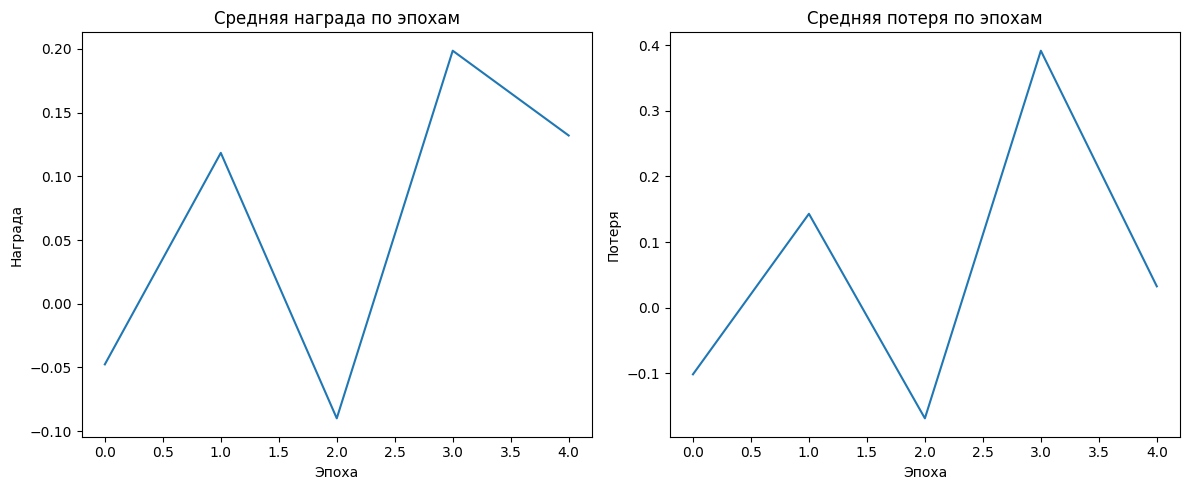

Улучшенное обучение PPO завершено!


In [79]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM
from datasets import load_dataset
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'  

def prepare_prompt(example):
    messages = [{"role": "user", "content": example["prompt"]}]
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return {"formatted_prompt": formatted_prompt}


dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.remove_columns(["chosen", "rejected"])
dataset = dataset.map(prepare_prompt)
dataset = dataset.train_test_split(test_size=0.1)


reward_model = AutoModelForSequenceClassification.from_pretrained(
    f"{REPO_NAME}-dpo",
    num_labels=1
)
reward_model.to(DEVICE)
reward_model.eval()

policy_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID, 
    attn_implementation="sdpa"
)
policy_model.to(DEVICE)
policy_model.train()

ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    attn_implementation="sdpa"
)
ref_model.to(DEVICE)
ref_model.eval()

def compute_reward(texts, reward_model, tokenizer):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        rewards = reward_model(**inputs).logits
    return rewards

def compute_logprobs_with_grad(model, input_ids, generated_ids):
    outputs = model(input_ids=input_ids)
    logits = outputs.logits
    
    log_probs = F.log_softmax(logits[:, :-1, :], dim=-1)
    targets = input_ids[:, 1:]
    
    gathered_logprobs = torch.gather(
        log_probs, 
        dim=2, 
        index=targets.unsqueeze(-1)
    ).squeeze(-1)
    
    mask = (targets != tokenizer.pad_token_id).float()
    seq_lengths = mask.sum(dim=1)
    token_logprobs = (gathered_logprobs * mask).sum(dim=1) / seq_lengths
    
    return token_logprobs

optimizer = torch.optim.AdamW(policy_model.parameters(), lr=2e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)


num_epochs = 5  
batch_size = 2
kl_coef = 0.05  

samples = dataset["train"].shuffle(seed=42).select(range(20))

all_rewards = []
all_losses = []

for epoch in range(num_epochs):
    epoch_rewards = []
    epoch_losses = []
    
    loop = tqdm(range(0, len(samples), batch_size), desc=f"Эпоха {epoch+1}/{num_epochs}")
    
    for i in loop:
        batch = samples[i:i+batch_size]
        prompts = batch["formatted_prompt"]
        
        inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(DEVICE)
        
        with torch.no_grad():
            generated_outputs = policy_model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=30,
                do_sample=True,
                temperature=0.7,
                return_dict_in_generate=True
            )
            
            generated_sequences = generated_outputs.sequences
            generated_texts = tokenizer.batch_decode(generated_sequences, skip_special_tokens=True)
            rewards = compute_reward(generated_texts, reward_model, tokenizer)
            ref_logprobs = compute_logprobs_with_grad(ref_model, generated_sequences, generated_sequences)
        
        
        policy_logprobs = compute_logprobs_with_grad(policy_model, generated_sequences, generated_sequences)
        kl_div = policy_logprobs - ref_logprobs.detach()
        policy_loss = -policy_logprobs * rewards.squeeze()
        kl_loss = kl_coef * kl_div
        loss = (policy_loss + kl_loss).mean()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_model.parameters(), 1.0)  
        optimizer.step()
        scheduler.step()
        mean_reward = rewards.mean().item()
        epoch_rewards.append(mean_reward)
        epoch_losses.append(loss.item())
        loop.set_postfix({"loss": f"{loss.item():.4f}", "reward": f"{mean_reward:.4f}"})
    
    all_rewards.append(np.mean(epoch_rewards))
    all_losses.append(np.mean(epoch_losses))
    
    print(f"Эпоха {epoch+1}/{num_epochs}, "
          f"Средняя потеря: {np.mean(epoch_losses):.4f}, "
          f"Средняя награда: {np.mean(epoch_rewards):.4f}")
    
    if (epoch+1) % 2 == 0:  
        print("Валидация...")
        val_samples = dataset["test"].select(range(3))
        for val_example in val_samples:
            prompt = val_example["formatted_prompt"]
            inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                outputs = policy_model.generate(
                    input_ids=inputs["input_ids"],
                    max_new_tokens=50,
                    do_sample=True,
                    temperature=0.7
                )
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print(f"Промпт: {prompt[:50]}...")
            print(f"Ответ: {generated_text[-100:]}...")
            print("-" * 40)

policy_model.save_pretrained(f"{REPO_NAME}-ppo")
tokenizer.save_pretrained(f"{REPO_NAME}-ppo")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(all_rewards)
plt.title('Средняя награда по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Награда')

plt.subplot(1, 2, 2)
plt.plot(all_losses)
plt.title('Средняя потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')

plt.tight_layout()
plt.savefig('ppo_training_progress.png')
plt.show()



Посмотрим на изменение в ответах. Вполне вероятно, что вы не увидите такого сильного изменения как после DPO. PPO требует гораздо больше ресурсов, правильных гиперпараметров и в целом не так стабилен.

In [80]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(DEVICE)

generated_ids = policy.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

init_generated_ids = ref_policy.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
init_response = tokenizer.batch_decode(init_generated_ids, skip_special_tokens=True)[0]

In [81]:
print("======== BEFORE TUNING ========")
print(init_response)
print()

print("======== AFTER TUNING ========")
print(response)

======== BEFORE TUNING ========
user
What's your morning routine like?
assistant
I'm excited to start my morning routine! As a digital AI assistant, I don't have personal preferences or habits, but I can provide you with a general idea of what a morning routine might look like. Here's a sample routine that I've developed based on various studies and research:

**Morning Routine (10-15 minutes)**

1. **Hydrate**: Drink a full glass of water or a herbal tea (e.g., chamomile, peppermint) to start the day.
2. **Eat a nutritious breakfast**: Prepare a healthy breakfast, such as oatmeal with fruit, scrambled eggs with spinach, or Greek yogurt with berries.
3. **Get some morning sunlight**: Spend 10-15 minutes outside in natural light to help regulate your circadian rhythms.
4. **Take a few deep breaths**: Inhale for 1-2 minutes, hold for 2-3 minutes, and exhale for 2-3 minutes.
5. **Stretch or move**: Engage in some light stretching or movement to get your blood flowing and your muscles movi

In [82]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-ppo")
tokenizer.push_to_hub(f"{REPO_NAME}-ppo")

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Pavelslavovich/llm-course-hw2-ppo/commit/331fde29df8a3b1261332ebae9b46e7536fd8a06', commit_message='Upload tokenizer', commit_description='', oid='331fde29df8a3b1261332ebae9b46e7536fd8a06', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Pavelslavovich/llm-course-hw2-ppo', endpoint='https://huggingface.co', repo_type='model', repo_id='Pavelslavovich/llm-course-hw2-ppo'), pr_revision=None, pr_num=None)

## Анализ модели [2 балл]

Проанализируйте финальный модель (от DPO и PPO).
Постройте графики логпроб для данных из обучающей выборки и сторонних, которые модель не видела.
Подойдет любой не сильно большой датасет с hugging face.

Считает ли финальная модель что данные из обучающей выборки более вероятны?

Попробуйте проанализировать финальную модель (от DPO или PPO). Постройте графики логпроб для данных из обучающей выборки и каких нибудь еще, которые модель не видела. Считает ли финальная модель что данные из обучающей выборки более вероятны?

Обрабатываем данные из обучающей выборки...


  0%|          | 0/100 [00:00<?, ?it/s]

Обрабатываем данные из сторонней выборки...


  0%|          | 0/100 [00:00<?, ?it/s]

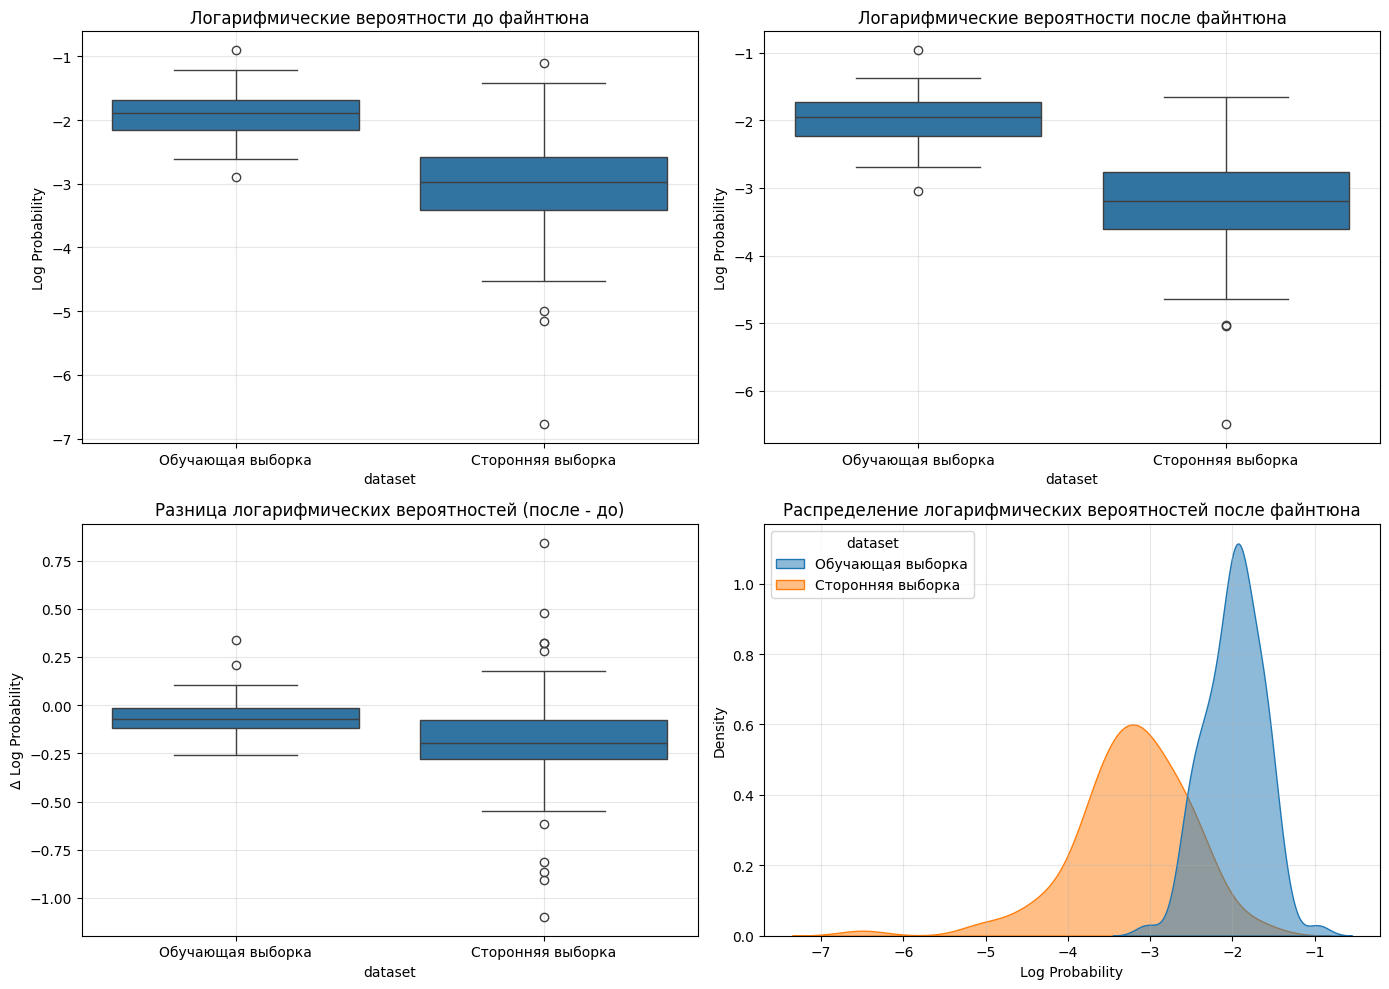


Статистика логарифмических вероятностей:
                  ref_log_prob           tuned_log_prob                diff  \
                          mean       std           mean       std      mean   
dataset                                                                       
Обучающая выборка    -1.919707  0.349714      -1.983160  0.347518 -0.063453   
Сторонняя выборка    -3.039300  0.786073      -3.225153  0.718368 -0.185853   

                             
                        std  
dataset                      
Обучающая выборка  0.091915  
Сторонняя выборка  0.250974  

T-статистика: 4.5796, P-значение: 0.0000
Разница статистически значима (p < 0.05)
Модель считает данные из обучающей выборки более вероятными


In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
from scipy import stats

ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    attn_implementation="sdpa",
    device_map=DEVICE
)
ref_model.eval()

dpo_model = AutoModelForCausalLM.from_pretrained(
    f"{REPO_NAME}-dpo",
    attn_implementation="sdpa",
    device_map=DEVICE
)
dpo_model.eval()

def calculate_log_probs(model, tokenizer, prompt, response):
    messages = [{"role": "user", "content": prompt}]
    chat_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    full_text = chat_text + response
    
    inputs = tokenizer(full_text, return_tensors="pt").to(DEVICE)
    
    prompt_tokens = tokenizer(chat_text, return_tensors="pt").input_ids.shape[1]
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    
    log_probs = []
    for i in range(prompt_tokens - 1, inputs.input_ids.shape[1] - 1):
        next_token_id = inputs.input_ids[0, i + 1].item()
        logit_for_token = logits[0, i]
        log_prob = F.log_softmax(logit_for_token, dim=0)[next_token_id].item()
        log_probs.append(log_prob)
    
    return sum(log_probs) / len(log_probs) if log_probs else 0

train_dataset = load_dataset(DATASET_ID, split="train").shuffle(seed=42).select(range(100))

unseen_dataset = load_dataset("Anthropic/hh-rlhf", split="train").shuffle(seed=42).select(range(100))

results = []

print("Обрабатываем данные из обучающей выборки...")
for i, example in enumerate(tqdm(train_dataset)):
    if i >= 100: 
        break
    
    prompt = example["prompt"]
    response = example["chosen"]
    

    ref_log_prob = calculate_log_probs(ref_model, tokenizer, prompt, response)
    dpo_log_prob = calculate_log_probs(dpo_model, tokenizer, prompt, response)
    
    results.append({
        "dataset": "Обучающая выборка",
        "ref_log_prob": ref_log_prob,
        "tuned_log_prob": dpo_log_prob,
        "diff": dpo_log_prob - ref_log_prob
    })

print("Обрабатываем данные из сторонней выборки...")
for i, example in enumerate(tqdm(unseen_dataset)):
    if i >= 100: 
        break
    
    prompt = example["chosen"].split("Human: ")[1].split("Assistant:")[0].strip()
    response = example["chosen"].split("Assistant:")[1].strip()
    
    ref_log_prob = calculate_log_probs(ref_model, tokenizer, prompt, response)
    dpo_log_prob = calculate_log_probs(dpo_model, tokenizer, prompt, response)
    
    results.append({
        "dataset": "Сторонняя выборка",
        "ref_log_prob": ref_log_prob,
        "tuned_log_prob": dpo_log_prob,
        "diff": dpo_log_prob - ref_log_prob
    })

df = pd.DataFrame(results)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x="dataset", y="ref_log_prob", data=df)
plt.title("Логарифмические вероятности до файнтюна")
plt.ylabel("Log Probability")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
sns.boxplot(x="dataset", y="tuned_log_prob", data=df)
plt.title("Логарифмические вероятности после файнтюна")
plt.ylabel("Log Probability")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
sns.boxplot(x="dataset", y="diff", data=df)
plt.title("Разница логарифмических вероятностей (после - до)")
plt.ylabel("Δ Log Probability")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
sns.kdeplot(data=df, x="tuned_log_prob", hue="dataset", fill=True, common_norm=False, alpha=0.5)
plt.title("Распределение логарифмических вероятностей после файнтюна")
plt.xlabel("Log Probability")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("logprobs_analysis.png")
plt.show()

print("\nСтатистика логарифмических вероятностей:")
print(df.groupby("dataset")[["ref_log_prob", "tuned_log_prob", "diff"]].agg(['mean', 'std']))

train_diff = df[df["dataset"] == "Обучающая выборка"]["diff"]
unseen_diff = df[df["dataset"] == "Сторонняя выборка"]["diff"]
t_stat, p_value = stats.ttest_ind(train_diff, unseen_diff)

print(f"\nT-статистика: {t_stat:.4f}, P-значение: {p_value:.4f}")
if p_value < 0.05:
    print("Разница статистически значима (p < 0.05)")
    if train_diff.mean() > unseen_diff.mean():
        print("Модель считает данные из обучающей выборки более вероятными")
    else:
        print("Модель считает данные из сторонней выборки более вероятными")
else:
    print("Разница статистически не значима (p >= 0.05)")

# Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Оформить репозитории на 🤗 (можно сделать коллекцию, так как у нас 3 репозитория): карточка модели с описанием задания, репортом качества и примерами генерации **[2 балла]**

# Специальный раздел для проверяющего

In [ ]:
device = torch.device("cuda")

DPO_REPO_NAME = f"{REPO_NAME}-dpo"
PPO_REPO_NAME = f"{REPO_NAME}-ppo"
REWARD_MODEL_REPO_NAME = f"{REPO_NAME}-reward-model"

tokenizer = AutoTokenizer.from_pretrained(DPO_REPO_NAME)
check_model = AutoModelForCausalLM.from_pretrained(DPO_REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

In [ ]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]

text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = check_model.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
response = tokenizer.decode(generated_ids, skip_special_tokens=True)[0]